In [1]:
import os
import sys
import numpy as np
import pandas as pd
import torch
from sklearn.utils import validation
from IPython.display import display
import ipywidgets as widgets

from functools import partial

MAIN_PATH = os.path.abspath(os.path.join('../src'))
sys.path.append(MAIN_PATH)

from proloaf.event_logging import create_event_logger
logger = create_event_logger('evaluate')

from proloaf import metrics
import proloaf.confighandler as ch
import proloaf.datahandler as dh
import proloaf.modelhandler as mh
import proloaf.tensorloader as tl

from proloaf.cli import parse_with_loss

# Using ProLoaF for hourly predictions of the German power consumption of the open power system data platform

## 1) Data Selection, Preprocessing, and Configuration of Forecasting Model

First, we need to make sure that we either use local or external data (preferably in csv or xlsx format). We make ProLoaF aware of the data-path and some details that need to be taken care of during pandas dataframe reading through or preprocessing config. For more infos on the confid checkout the [configuration-helper](https://acs.pages.rwth-aachen.de/public/automation/plf/proloaf/docs/files-and-scripts/config/)

> **NOTE:** If you start with your forecasting task already with all features integrated in one csv file, you can skip the whole preprocessing step.

We now use preprocess.py to do the job of importing, interpolation, aligning the timesteps, taking the minimum joint period of input data, and generating one hot encoding and cyclical encoding of calendric data, that is based on the timestamp.
More infos on the interpolation techniques is explained in [this notebook-section](./Step-by-step%20user%20guide%20on%20train.py.ipynb#1.-Dealing-with-missing-values-in-the-data).

In [2]:
!python ../src/preprocess.py -s opsd

2024-12-17 10:29:29 - datahandler - INFO - Importing CSV Data...
2024-12-17 10:29:29 - datahandler - INFO - Importing time_series/2020-10-06/time_series_60min_singleindex.csv ...
2024-12-17 10:29:53 - datahandler - INFO - ...Importing finished. 
2024-12-17 10:29:53 - datahandler - INFO - Importing weather_data/2020-09-16/weather_data.csv ...
2024-12-17 10:30:35 - datahandler - INFO - ...Importing finished. 
2024-12-17 10:30:35 - datahandler - INFO - Some values are NaN. They are being filled...
2024-12-17 10:30:35 - datahandler - INFO - ...interpolation finished! No missing data left.
                     AT_load_actual_entsoe_transparency  DE_load_actual_entsoe_transparency
Time                                                                                       
2014-12-31 23:00:00                              5946.0                             41151.0
2015-01-01 00:00:00                              5946.0                             41151.0
2015-01-01 01:00:00                     

## 2) Training

You can use the shell command to train the model, or run train.py with your IDE (the latter requires you to set script variables, such as '-s <station_name>' in your run/debug configuration), to apply the confugrations that are set in your targets/<station_name> folder:

```python ../src/train.py -s opsd```

In [3]:
!python ../src/train.py -s opsd --smoothed_quantiles 0.025 0.5 0.975

2024-12-17 10:30:41 - train - INFO - Current working directory is C:\Users\s.madhavanreshikesh2\OneDrive - Shell\Documents\GitHub\proloaf
2024-12-17 10:30:41 - modelhandler - DEBUG - exploration = False
2024-12-17 10:30:41 - modelhandler - DEBUG - self.model_class = 'recurrent'
2024-12-17 10:30:41 - modelhandler - DEBUG - self.model_parameters = {'recurrent': {'core_net': 'torch.nn.LSTM', 'core_layers': 1, 'dropout_fc': 0.4, 'dropout_core': 0.3, 'rel_linear_hidden_size': 1.0, 'rel_core_hidden_size': 1.0, 'relu_leak': 0.1}, 'simple_transformer': {'num_layers': 3, 'dropout': 0.4, 'n_heads': 6}}
2024-12-17 10:30:41 - loghandler - INFO - Tensorboard log here:	 C:\Users\s.madhavanreshikesh2\OneDrive - Shell\Documents\GitHub\proloaf\runs\2024-12-17 10-30-41\trial_main
2024-12-17 10:30:43 - tensorloader - DEBUG - frame not prepared
2024-12-17 10:30:43 - datahandler - INFO - No missing data
2024-12-17 10:30:43 - tensorloader - DEBUG - frame not prepared
2024-12-17 10:30:43 - datahandler - INFO


This command looks for a configuration file in your proloaf project folder: targets/opsd/config.json, which contains all settings of the forecasting model that is to be built. One can further specify here which loss function is being used for the training, which is affecting the score per epoch that is minimized. For the scoring methods, please visit the [documentation](https://sogno.energy/proloaf/reference/proloaf/proloaf/metrics.html).

Upon sucessful run of train.py, it will generate a trained RNN model that is stored in the path 'oracles'.
In the case that a forecasting model under the same name already exists, the two models will be benchmarked. The model with the best score will 1) remain the same, if the previous model was more accurate, or 2) will replace the old model as the new model is more accurate.
A step-by-step guide to what is done in train.py follows in [this notebook](./Step-by-step%20user%20guide%20on%20train.py.ipynb).

### 3) ProLoaF Performance Check
We now want to give a deeper look into the 24h-forecast the RNN is able to generate.

### Read in config file and set active paths 
Assuming opsd exists in 'targets' and the model has been trained already, so it is stored in 'oracles' (see step 2))

In [4]:
config_path = 'opsd'
PAR = ch.read_config(config_path, main_path="../")
torch.manual_seed(1)
model_name = PAR["model_name"]
data_path = PAR["data_path"]
INFILE = os.path.join("../", data_path)  # input factsheet
INMODEL = os.path.join("../", PAR["output_path"], model_name)
OUTDIR = os.path.join("../", PAR["evaluation_path"])
DEVICE = "cpu"

target_id = PAR["target_id"]
SPLIT_RATIO = PAR["validation_split"] # Data that has not been used *at all* during training, also not for testing
HISTORY_HORIZON = PAR["history_horizon"]
FORECAST_HORIZON = PAR["forecast_horizon"]
feature_groups = PAR["feature_groups"]

if not os.path.exists(OUTDIR):
    os.makedirs(OUTDIR)

### Load Data, Interpolate any missing values, and Split to use Test-Set only

In [5]:
# Read load data
df = pd.read_csv(INFILE, sep=";", index_col=0, parse_dates=True)

In [6]:
#Originally we have trained the model to predict 24h ahead.
adj_forecast_horizon = widgets.IntSlider(value=PAR["forecast_horizon"])
display(adj_forecast_horizon)

IntSlider(value=24)

In [7]:
FORECAST_HORIZON = adj_forecast_horizon.value

### Re-load Trained RNN and Generate Tensor using ProLoaF Tensor-Dataloader 'TimeSeriesData'
For anything that concerns the handling of the model, such as saving and loading a forecasting model, the ModelHandler class is beeing used. Accordingly the datahandler class is dedicated to all actions on original input data, such as generation of features, or time-series handling.

In [8]:
with torch.no_grad():
    net = mh.ModelHandler.load_model(f"{INMODEL}.pkl", locate=DEVICE)
    
    # Here we split the data still in pandas dataframe format into two parts. 
    # The split ratio is here really to seperate the data that was not seen during training, also not for validation purposes.
    train_df, test_df = dh.split(df, [SPLIT_RATIO])
    ## Now we create a tensor that also still contains the original dataframe. 
    test_data = tl.TimeSeriesData(
        test_df,
        device=DEVICE,
        ## Before the tensor object is created, all listed preparation steps are applied to the pandas dataframe
        ## Depending on the underlying data, some steps can be skipped, by simply removing the item from the list
        preparation_steps=[
                partial(dh.set_to_hours, freq="1H"),# Here you can specify a datetime frequency. Default: '1H'
                partial(dh.fill_if_missing, periodicity=PAR.get("periodicity", 24)),
                dh.add_cyclical_features,
                dh.add_onehot_features,
                net.scalers.transform,
                dh.check_continuity,
            ],
        **PAR,
    )
    prepped_data = test_data.make_data_loader(batch_size=None, shuffle=False)

2024-12-17 10:41:50 - tensorloader - DEBUG - frame not prepared
2024-12-17 10:41:50 - datahandler - INFO - No missing data


c:\Users\s.madhavanreshikesh2\OneDrive - Shell\Documents\GitHub\proloaf\src\proloaf\modelhandler.py:934: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  inst = torch.load(path

Let us return the content of test_data as a dataframe:

In [9]:
prepped_data.dataset.data

,AT_load_actual_entsoe_transparency,DE_load_actual_entsoe_transparency,AT_temperature,AT_radiation_direct_horizontal,AT_radiation_diffuse_horizontal,DE_temperature,DE_radiation_direct_horizontal,DE_radiation_diffuse_horizontal,hour_sin,hour_cos,...,month_10,month_11,month_12,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
Time,,,,,,,,,,,,,,,,,,,,,
2018-12-31 19:00:00,6846.0,50094.0,-1.205,0.0,0.0,4.963,0.0,0.0,-0.965926,0.258819,...,False,False,True,True,False,False,False,False,False,False
2018-12-31 20:00:00,6473.0,47993.0,-1.408,0.0,0.0,5.005,0.0,0.0,-0.866025,0.500000,...,False,False,True,True,False,False,False,False,False,False
2018-12-31 21:00:00,6569.0,47476.0,-1.614,0.0,0.0,4.992,0.0,0.0,-0.707107,0.707107,...,False,False,True,True,False,False,False,False,False,False
2018-12-31 22:00:00,6290.0,45636.0,-1.688,0.0,0.0,4.905,0.0,0.0,-0.500000,0.866025,...,False,False,True,True,False,False,False,False,False,False
2018-12-31 23:00:00,6075.0,42976.0,-1.666,0.0,0.0,4.843,0.0,0.0,-0.258819,0.965926,...,False,False,True,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00,6748.0,47493.0,-1.386,0.0,0.0,0.767,0.0,0.0,-0.965926,0.258819,...,False,False,True,False,True,False,False,False,False,False
2019-12-31 20:00:00,6429.0,45842.0,-1.661,0.0,0.0,0.656,0.0,0.0,-0.866025,0.500000,...,False,False,True,False,True,False,False,False,False,False
2019-12-31 21:00:00,6492.0,45501.0,-1.986,0.0,0.0,0.476,0.0,0.0,-0.707107,0.707107,...,False,False,True,False,True,False,False,False,False,False


In [10]:
prepped_data.dataset.get_as_frame

<bound method TimeSeriesData.get_as_frame of <proloaf.tensorloader.TimeSeriesData object at 0x0000022F5FBF3890>>

Or filter for one day out of the test set by either the index value (string) or location (int). Return as dataframe

In [11]:
prepped_data.dataset.get_as_frame("2019-01-01 00:00:00")

(                     AT_load_actual_entsoe_transparency  \
 Time                                                      
 2019-01-01 00:00:00                              5852.0   
 2019-01-01 01:00:00                              5619.0   
 2019-01-01 02:00:00                              5324.0   
 2019-01-01 03:00:00                              5273.0   
 2019-01-01 04:00:00                              5439.0   
 ...                                                 ...   
 2019-01-06 22:00:00                              6754.0   
 2019-01-06 23:00:00                              6387.0   
 2019-01-07 00:00:00                              6090.0   
 2019-01-07 01:00:00                              5962.0   
 2019-01-07 02:00:00                              5875.0   
 
                      DE_load_actual_entsoe_transparency  DE_temperature  \
 Time                                                                      
 2019-01-01 00:00:00                             41562.0          

All earlier preparation steps, such as scaling, has been applied to the torch tensor part of the dataloader. The original pandas dataframe included in the dataloader is not affected by the preparators steps, unless the user calls ```test_data.apply_prep_to_frame()```. This hybrid (torch-pandas) structure of the tensorloader is chosen to have maximum control over the dataset before, during and after the training process, and even to compare non-prepared and prepared data.

Later, during training the above mentioned data is converted to features that have selective time windows and sample sizes depending on the chosen encoder (=history) length and decoder (=future forecast) length. This step, i.e., the creating of the dataloader is postponed to just priot to the first training step, as the data handling can be one measure to tune the forecast model. This way, we can optimize for instance the selected encoder length, decoder length or batch size from one training trial to another. 

The data will be built to a three 3D-tensors during training, where:
- the 1st dimension determines the number of samples: How many distinct time instances are going to be trained? 
- the 2nd dimension determines the time horizon
    - Encoder: How many timesteps are considered as historic information per sample? 
    - Decoder: How many timesteps are considered as future information per sample?)
- the 3rd dimension reflects the number of features that are present in the tensor (seperately adjustable for encoder, decoder and target tensor).

Imagine the 3D-tensor to have these dimensions as mentioned above
![Grafik](./figures/3d-tensor.jpg)

We can further fetch the keys of the features per tensor from the tensorloader, that is structured in encoder, decoder, and target features. In our example we have following features thar are selected from the prepared data:

In [12]:
print("Encoder Features:", prepped_data.dataset.encoder_features, "\n", )

print("Decoder Features:", prepped_data.dataset.decoder_features,"\n")

print("Targets:", prepped_data.dataset.target_id, "\n")

Encoder Features: ['AT_load_actual_entsoe_transparency', 'DE_load_actual_entsoe_transparency', 'DE_temperature', 'DE_radiation_direct_horizontal', 'DE_radiation_diffuse_horizontal'] 

Decoder Features: ['hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'hour_sin', 'weekday_sin', 'mnth_sin'] 

Targets: ['DE_load_actual_entsoe_transparency'] 



### Fetch prediction upper bounds, lower bounds and mean expected values

Let's select one specific day, at which we will produce a forecast, e.g. 01.01.2019, First we load the inputs both for the encoder and decoder.

In [13]:
forecast_sample=prepped_data.dataset.data.index.get_loc("2019-01-01 00:00:00")
inputs_enc, inputs_dec, targets = prepped_data.dataset[forecast_sample]

We now call the predict function and pass the network the inputs structured as encoder inputs and decoder inputs

In [14]:
print("Historic encoder inputs with shape ([n_timesteps, n_features]):",inputs_enc.shape, "\nand future decoder inputs with shape ([n_timesteps, n_features]):", inputs_dec.shape)

Historic encoder inputs with shape ([n_timesteps, n_features]): torch.Size([147, 5]) 
and future decoder inputs with shape ([n_timesteps, n_features]): torch.Size([24, 46])


In [15]:
with torch.no_grad():
    prediction = net.predict(inputs_enc.unsqueeze(0), inputs_dec.unsqueeze(0))
prediction

tensor([[[0.4849, 0.2339, 0.3969],
         [0.5764, 0.2599, 0.4835],
         [0.7346, 0.3217, 0.6198],
         [0.8834, 0.4054, 0.7507],
         [0.9448, 0.4668, 0.8067],
         [0.9681, 0.5182, 0.8300],
         [0.9978, 0.5508, 0.8572],
         [1.0222, 0.5779, 0.8794],
         [1.0174, 0.5769, 0.8758],
         [0.9958, 0.5701, 0.8577],
         [0.9628, 0.5613, 0.8299],
         [0.9395, 0.5581, 0.8103],
         [0.9381, 0.5672, 0.8092],
         [0.9953, 0.6093, 0.8593],
         [1.0205, 0.6339, 0.8819],
         [0.9857, 0.6225, 0.8519],
         [0.8832, 0.5746, 0.7633],
         [0.7957, 0.5221, 0.6871],
         [0.7345, 0.4859, 0.6329],
         [0.6321, 0.4149, 0.5426],
         [0.5423, 0.3394, 0.4623],
         [0.4905, 0.3029, 0.4168],
         [0.4702, 0.2858, 0.3990],
         [0.4784, 0.2940, 0.4061]]])

This process is score dependent. Thus, the output can have different meanings, depending on which score was used during training. To make clear what the output (=predictions) from the neural network consists of, you can return its labels. Per default, ProLoaF trains with GNLL (=Negative Log-Likelihood under the assumption of a Standard-Normal Distribution), so the output will be the expected value (mean) and log variance, which can be transformed into a Gaussian distribution with upper and lower bands. Per default we assume a confidence band of 95%.

In [16]:
print("Trained", net.name, "with", net.loss_metric.id, "resulting in following outputs:", net.output_labels)

Trained opsd_recurrent with SmoothedPinnballLoss resulting in following outputs: ['quant[0.975]', 'quant[0.025]', 'quant[0.5]']


To now create the upper and lower bands from the distribution or non-parametric output, we generate the quantiles:

In [17]:
quantile_prediction = net.loss_metric.get_quantile_prediction(
    predictions=prediction, target=targets.unsqueeze(0)
)

expected_values = quantile_prediction.get_quantile(0.5)
y_pred_upper = quantile_prediction.select_upper_bound().values.squeeze(
    dim=2
)
y_pred_lower = quantile_prediction.select_lower_bound().values.squeeze(
    dim=2
)

##The lower and upper bound can now be returned seperately: 
#quantile_prediction.select_lower_bound().values
#quantile_prediction.select_upper_bound().values

#or together with the mean value:
quantile_prediction.values

tensor([[[0.4849, 0.2339, 0.3969],
         [0.5764, 0.2599, 0.4835],
         [0.7346, 0.3217, 0.6198],
         [0.8834, 0.4054, 0.7507],
         [0.9448, 0.4668, 0.8067],
         [0.9681, 0.5182, 0.8300],
         [0.9978, 0.5508, 0.8572],
         [1.0222, 0.5779, 0.8794],
         [1.0174, 0.5769, 0.8758],
         [0.9958, 0.5701, 0.8577],
         [0.9628, 0.5613, 0.8299],
         [0.9395, 0.5581, 0.8103],
         [0.9381, 0.5672, 0.8092],
         [0.9953, 0.6093, 0.8593],
         [1.0205, 0.6339, 0.8819],
         [0.9857, 0.6225, 0.8519],
         [0.8832, 0.5746, 0.7633],
         [0.7957, 0.5221, 0.6871],
         [0.7345, 0.4859, 0.6329],
         [0.6321, 0.4149, 0.5426],
         [0.5423, 0.3394, 0.4623],
         [0.4905, 0.3029, 0.4168],
         [0.4702, 0.2858, 0.3990],
         [0.4784, 0.2940, 0.4061]]])

### Let's plot those predictions

In [18]:
import proloaf.plot as plot

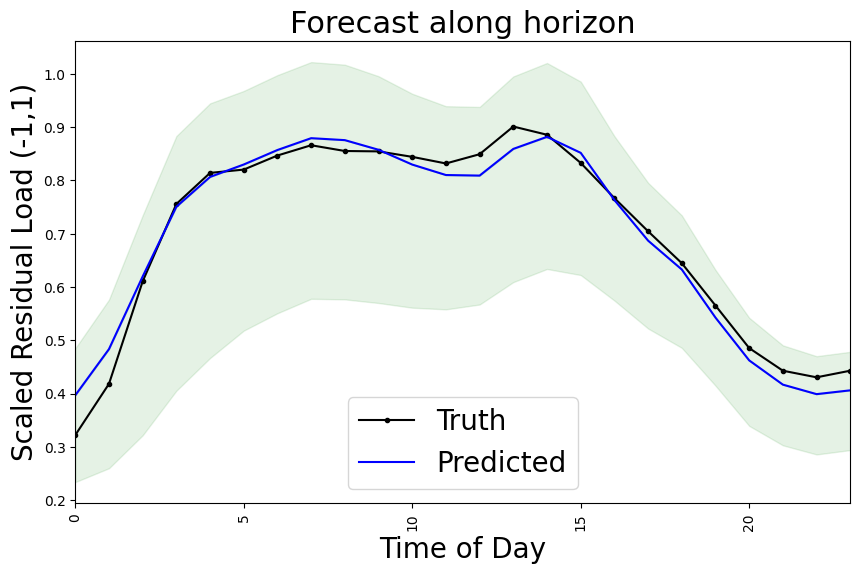

In [19]:
# Fetch the actual time from the datetimeindex in the pandas dataframe
actual_time = pd.Series(pd.to_datetime(df.index), index=df.index, dtype=object)
actuals = actual_time[forecast_sample : forecast_sample + FORECAST_HORIZON]
plot.plot_timestep(
    targets.detach().squeeze().numpy(),
    expected_values.detach().numpy()[0],
    y_pred_upper.detach().numpy()[0],
    y_pred_lower.detach().numpy()[0],
    forecast_sample,
    OUTDIR,
    PAR["cap_limit"],
    actuals,
)

One can also plot a desired limit, to visually indicate congestion in high load situations.


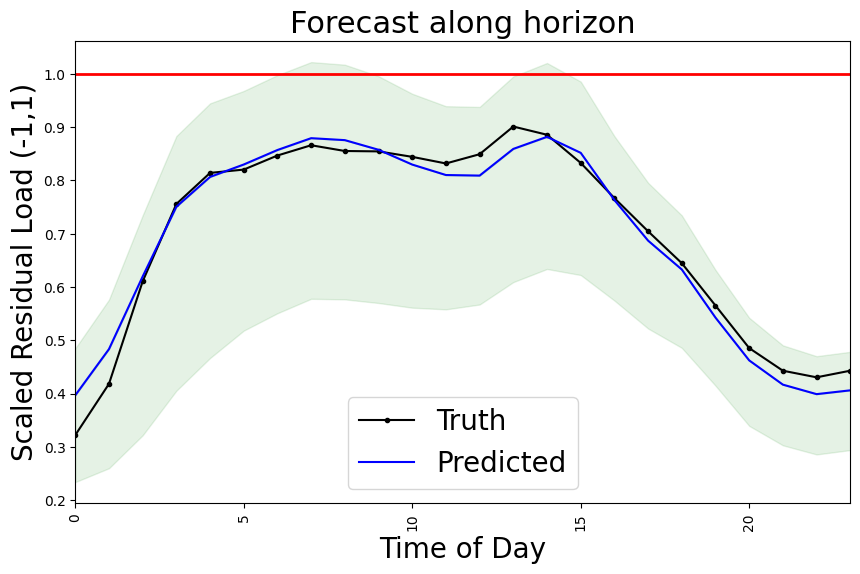

In [20]:
# Plot for days with possible congestion
print("One can also plot a desired limit, to visually indicate congestion in high load situations.")
plot.plot_timestep(
    targets.detach().squeeze().numpy(),
    expected_values.detach().numpy()[0],
    y_pred_upper.detach().numpy()[0],
    y_pred_lower.detach().numpy()[0],
    forecast_sample,
    OUTDIR,
    PAR["cap_limit"],
    actuals,
    draw_limit=True
)

### Let's Calculate the Deterministic and Probabilistic Forecast Metrics on the Test Set

First list all evaluation metrics that are of interest. You can refer to the description of the most common metrics of this project [here](./A%20User%20Guide%20on%20the%20ProLoaF%20Forecast%20Performance%20Metrics.ipynb).
Here is an example how to prepare the test metrics object, to lateron fetch RMSE, MAE, Residuals, Quantile Score etc.:

In [21]:
test_metrics_total = [
            metrics.NllGauss(),
            metrics.Mse(),
            metrics.Rmse(),
            metrics.Sharpness(),
            metrics.Picp(),
            metrics.Rae(),
            metrics.Mae(),
            metrics.Mis(),
            metrics.Mase(),
            metrics.PinnballLoss(),
            metrics.Residuals(),
        ]

### How does the forecast model perform on average?
We call our benchmark function. Here we do not limit our evaluation to a single forecast sample but average the performance over all hours in the test data

In [22]:
results_total_per_forecast = (
    mh.ModelHandler.benchmark(
        test_data,
        [net],
        test_metrics=test_metrics_total,
        avg_over="all",
    )
    .iloc[0]
    .unstack()
)
results_total_per_forecast

2024-12-17 10:41:53 - tensorloader - DEBUG - tensor already prepared
2024-12-17 10:41:53 - modelhandler - INFO - benchmarking opsd_recurrent


,NllGauss,Mse,Rmse,Sharpness,Picp,Rae,Mae,Mis,Mase,PinnballLoss,Residuals
opsd_recurrent,-2.452855,0.003593,0.059944,0.253496,97.374443,0.212915,0.039754,0.076443,0.964259,0.026747,0.000025


### Does the prediction perform equally good or bad over the whole test set?
We have fetched the predictions over the chosen forecast horizon for every hour in the test set. Let us visualize how this is done.

![Grafik](./figures/tensor-structure.jpg)
Since every sample is shifted by a time-delta, or let's say a sample-frequency (in the figure: frequency=1), we achieve as many samples as is possible by the given data set. So we first arrange our forecast from the whole dataset by specifying that the test_metrics need to be calculated per sample (meaning averaging over the timesteps in the forecast horizon):

2024-12-17 10:41:53 - tensorloader - DEBUG - tensor already prepared
2024-12-17 10:41:53 - modelhandler - INFO - benchmarking opsd_recurrent
A boxplot will serve as the most practical plot to show how much the error metrics deviate
from one forecast situation to another. We refer to each forecast situation as one sample.


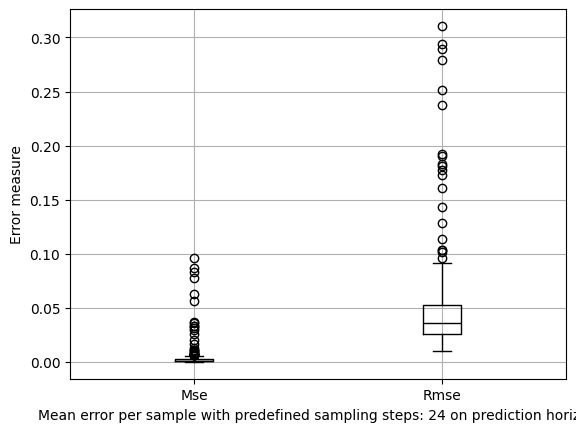

Remember that the number of test samples is 8595 .
The period ranges from Mon, 2018-12-31 to Tue, 2019-12-31 .
For sake of clarity we have plotted the samples in 24h intervals resulting in: 358 days in the test set.


In [23]:
## Specify which metrics to look into per sample
test_metrics_sample = [metrics.Mse(), metrics.Rmse()]

## RESULTS PER SAMPLE
results_per_sample_per_forecast = mh.ModelHandler.benchmark(
    test_data,
    [net],
    test_metrics=test_metrics_sample,
    avg_over="time",
)

print("A boxplot will serve as the most practical plot to show how much the error metrics deviate\nfrom one forecast situation to another. We refer to each forecast situation as one sample.")
# BOXPLOTS
with torch.no_grad():
    plot.plot_boxplot(
        metrics_per_sample=results_per_sample_per_forecast[net.name],
        sample_frequency=24, ## choose here the sample-frequencyy. It is set to 24 steps, here 24 hours = daily
        save_to=OUTDIR,
    )
print("Remember that the number of test samples is", len(test_data), ".")
print("The period ranges from", test_data.data.index[0].strftime("%a, %Y-%m-%d"), "to", test_data.data.index[-1].strftime("%a, %Y-%m-%d"), ".")
print("For sake of clarity we have plotted the samples in 24h intervals resulting in:", int(len(test_data)/24), "days in the test set.")

2024-12-17 10:41:54 - tensorloader - DEBUG - tensor already prepared
2024-12-17 10:41:54 - modelhandler - INFO - benchmarking opsd_recurrent


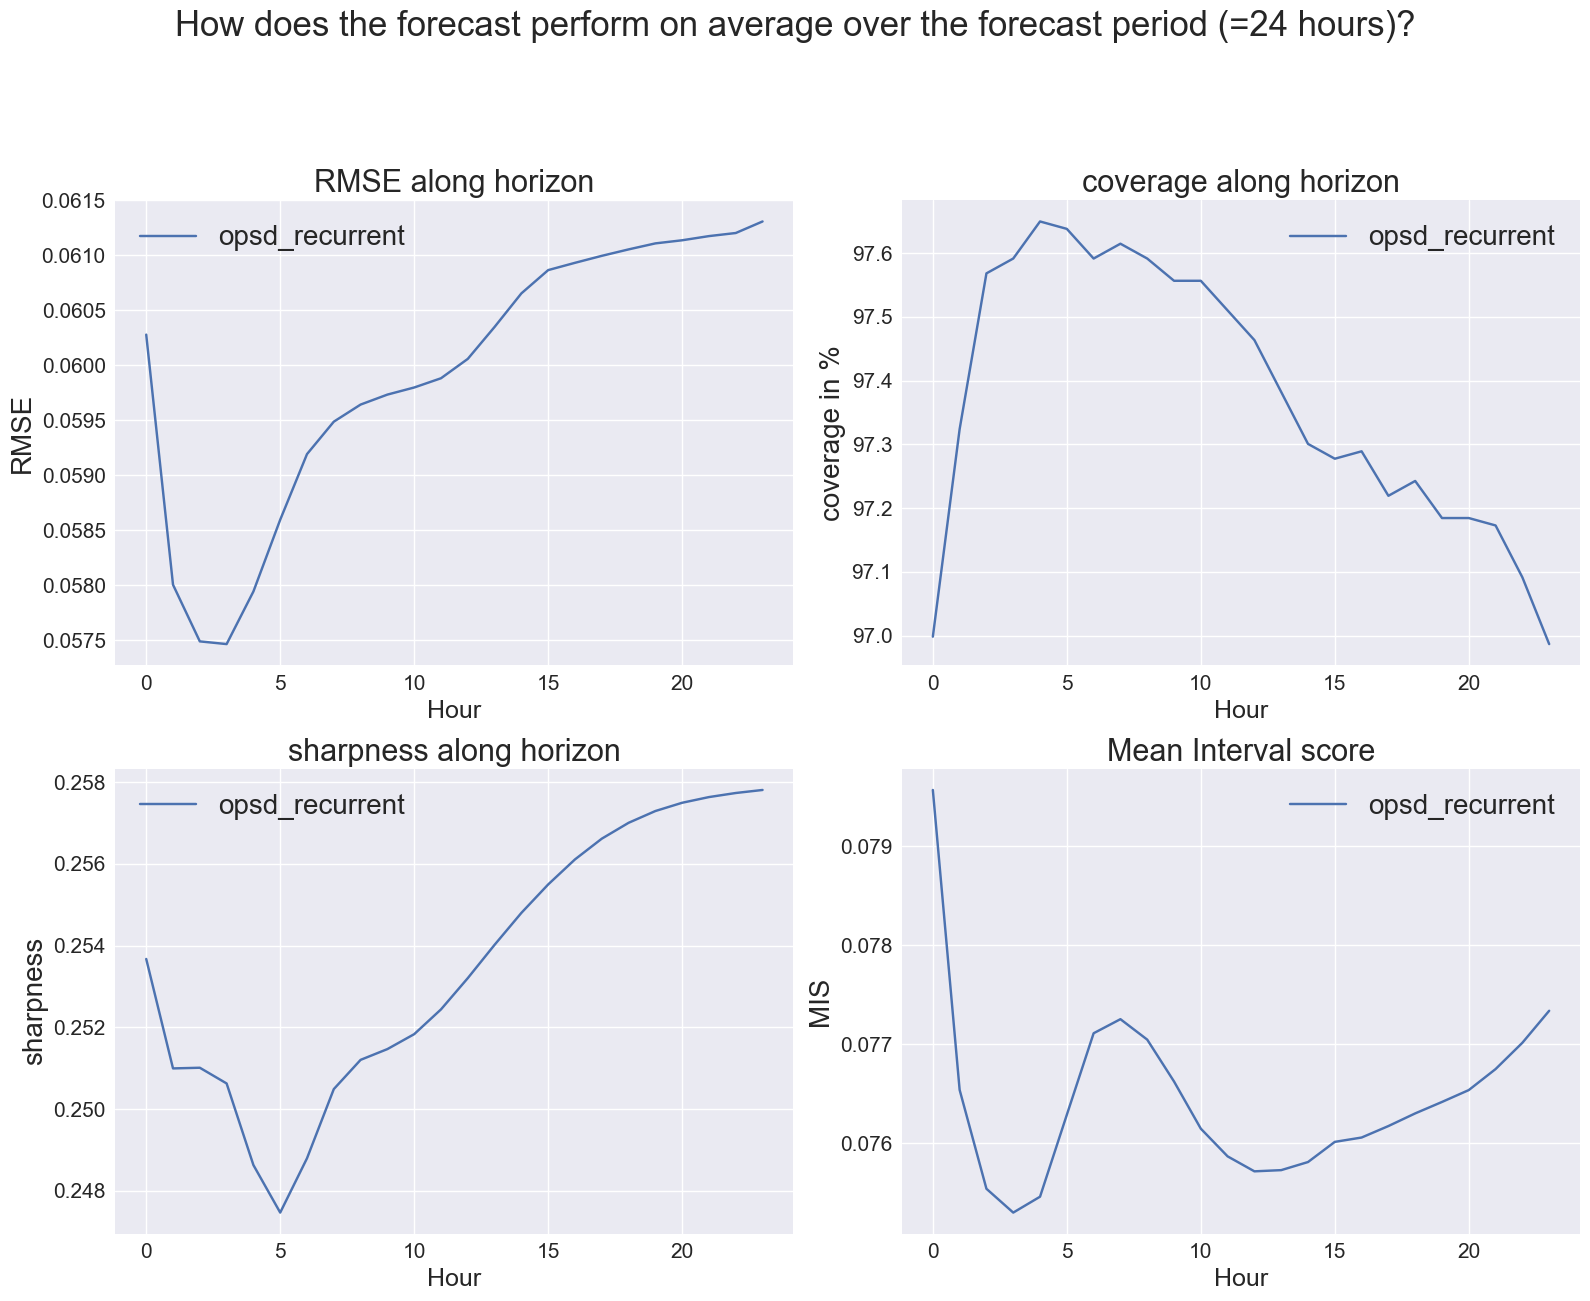

In [24]:
#first fetch the metrics per time step on the forecast horizon (=24 hours in our case)
test_metrics_timesteps = [
    metrics.NllGauss(),
    metrics.Rmse(),
    metrics.Sharpness(),
    metrics.Picp(),
    metrics.Mis(),
]

results_per_timestep_per_forecast = mh.ModelHandler.benchmark(
    test_data,
    [net],
    test_metrics=test_metrics_timesteps,
    avg_over="sample",
)

rmse_values = pd.DataFrame(
    data=results_per_timestep_per_forecast.xs(
        "Rmse", axis=1, level=1, drop_level=True
    ),
    columns=[net.name],
)
sharpness_values = pd.DataFrame(
    data=results_per_timestep_per_forecast.xs(
        "Sharpness", axis=1, level=1, drop_level=True
    ),
    columns=[net.name],
)
picp_values = pd.DataFrame(
    data=results_per_timestep_per_forecast.xs(
        "Picp", axis=1, level=1, drop_level=True
    ),
    columns=[net.name],
)
mis_values = pd.DataFrame(
    data=results_per_timestep_per_forecast.xs(
        "Mis", axis=1, level=1, drop_level=True
    ),
    columns=[net.name],
)

plot.plot_metrics(
    rmse_values,
    sharpness_values,
    picp_values,
    mis_values,
    OUTDIR,
    title="How does the forecast perform on average over the forecast period (=24 hours)?"
)